<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab10_curse_of_dimensionality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.integrate import quad, nquad, simpson
from matplotlib import pyplot as plt

# Lab 10: curse of dimensionality and integration

The "curse of dimensionality" is a term thrown around a lot these days, and it means different things to different people and in different contexts.  One context in which it is used is when the work required to reach a fixed accuracy grows exponentially in the dimension.

We'll explore this phenomenon in the context of integration, and compare two methods (quadrature vs Monte Carlo) which have very different pros and cons.

- Bonus: if you're interested in a method that mixes the pros and cons of each approach, look into **quasi Monte Carlo** methods. I have a [demo on quasi-Monte Carlo](https://github.com/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo14_MonteCarlo_and_improvements.ipynb) that I made for a different class

## Part 1: quadrature in 1D

"Quadrature" refers to numerical integration where we sample points from the domain and use specific weights associated with those points to form our estimate of the integral (in contrast, Monte Carlo and Quasi-Monte Carlo are sometimes defined to be estimates in which the weights never change from point to point, though that definition is too vague to be illuminating at this point).

For example, the midpoint rule, [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule), and [Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) (and their composite version) are quadrature methods, as are things like [Gauss-Legendre](https://en.wikipedia.org/wiki/Gaussian_quadrature) and [Clenshaw-Curtis](https://en.wikipedia.org/wiki/Clenshaw%E2%80%93Curtis_quadrature).

We won't investigate these in detail, as we'll use `scipy.integrate.quad` to do the work for us (and it adaptively chooses the number of nodes in order to reach a target accuracy), but it helps to think of these as just Riemann sums.

Throughout this lab, we'll work with the function $f(x)=\sin(x)$, or in higher dimensions with $\vec{x}\in\mathbb{R}^d$, then
$$f(\vec{x}) = \prod_{i=1}^d \sin(x_i)$$
and our goal is to estimate its integral
$$\widetilde{I} = \int_{a}^{b} f(x)dx$$
or more generally if $d\ge 1$
$$\widetilde{I} = \int_{a}^{b}\int_{a}^{b} \ldots \int_{a}^{b} f(\vec{x})dx_1 dx_2 \ldots dx_d.$$
We chose $f$ to be a simple function so that you can workout the answer by hand.

When $d>1$, let's actually look at
$$I = \widetilde{I}^{1/d}$$
since the value of this will not depend on the dimension.

### Part 1a: determine the value of $I$ by hand for $a=0$ and $b=\pi$
... so that you can check your answer.

Do this for any **arbitrary** dimension $d\in\mathbb{N}$.

And in fact if $b=k \pi$ for any integer $k$, you can easily work out the true answer also.

In [3]:
def trueIntegral(a=0,b=None):
    if b is None:
        # default value is b = pi, in which case we have the exact answer to infinite precision:
        return 2
    else:
        return -np.cos(b) + np.cos(a)

### Part 1b: accuracy vs number of points
For $a=0$ and $b=\pi$, compute the quadrature with a varying number of points, and **plot** the error vs the number of points.

Do this for 1d only (for now)

Do this using Simpson's rule (`scipy.integrate.simpson`), giving it a fixed grid of nodes (e.g., `x=np.linspace(...)`) so that you can control the accuracy (if you use `scipy.integrate.quad`, it's a bit harder to force it to give you low accuracy)

- **Bonus** question: if we choose $b=2\pi$ (and adjust our true answer accordingly), how does the error decay with the number of points? Did you expect this?  (good undergrad numerics books should discuss this; the phenomenon is **spectral accuracy**; see, e.g., [this paper](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=29d832b1235e61ad5445bceb90ecf8a2bf857044) which has links to some textbooks in the references).

nNodes=  11, integral=    2.000110, error 1.10e-04
nNodes=  15, integral=    2.000028, error 2.83e-05
nNodes=  23, integral=    2.000005, error 4.63e-06
nNodes=  35, integral=    2.000001, error 8.11e-07
nNodes=  53, integral=    2.000000, error 1.48e-07
nNodes=  81, integral=    2.000000, error 2.64e-08
nNodes= 123, integral=    2.000000, error 4.89e-09
nNodes= 187, integral=    2.000000, error 9.04e-10
nNodes= 285, integral=    2.000000, error 1.66e-10
nNodes= 433, integral=    2.000000, error 3.11e-11
nNodes= 657, integral=    2.000000, error 5.84e-12
nNodes=1001, integral=    2.000000, error 1.08e-12


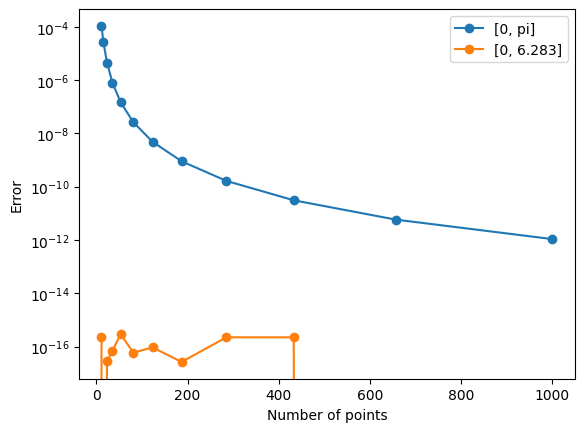

In [4]:
def f(x):
    return np.sin(x)
a = 0

errHist = []
nodeList = []
for nNodes in np.logspace(1, 3, 12, dtype=np.int64):
    # want nNodes to be odd for Simpson's rule
    if nNodes % 2 == 0:
        nNodes += 1
    nodeList.append(nNodes)

    b = np.pi
    x = np.linspace(a, b, nNodes)
    integral = simpson(f(x),x=x)
    print(f'{nNodes=:4d}, {integral=:12.6f}, error {np.abs(integral-trueIntegral(a,b)):.2e}')
    err = np.abs(integral-trueIntegral(a,b))

    b = 2*np.pi
    x = np.linspace(a, b, nNodes)
    integral = simpson(f(x),x=x)
    err2 = np.abs(integral-trueIntegral(a,b))
    errHist.append( [err,err2] )

errHist = np.array(errHist)

plt.semilogy( nodeList, errHist[:,0], 'o-', label=f'[0, pi]' )
plt.semilogy( nodeList, errHist[:,1], 'o-', label=f'[0, {b:.3f}]' )
plt.xlabel('Number of points')
plt.ylabel('Error')
plt.legend()
plt.show()

**Solution comments**

The error decays pretty quickly as a function of number of points!  The error seems to stagnate, but this is likely due to roundoff -- we only have about 16 digits of precision to work with anyhow

For the interval $[0,2\pi]$, here $f$ is periodic (and so is its derivative...), so there's not really any thing like a "boundary" node, and that makes things easier.

In fact, we get spectral convergence. Basically, one way to think about it is that low-accuracy methods like midpoint rule are equivalent to higher accuracy methods (Simpson's rule) and even higher-order methods... and the improvement decays (as a function of spacing between nodes) faster than any polynomial decay.

In [177]:
# IGNORE: trying to get the above plot using 'quad' but the accuracy
#   is always all-or-nothing
# a, b = 0, 99.5*np.pi
# def f(x):
#     return np.sin(x)

# for tol in np.logspace(-5, 3, 12):
#     opts = dict(epsabs = tol, epsrel = tol, limit = int(1e4) )
#     allOutputs = quad(f, a, b, full_output=True, epsabs=tol,epsrel=tol )
#     integral = allOutputs[0]
#     info     = allOutputs[2]
#     print(f'{integral=:12.6f}, error {np.abs(integral-trueIntegral(a,b)):.2e}, fcn evals {info["neval"]:4d}')

### Part 1c: quadrature error as a function of dimension
Now we can use `scipy.integrate.quad` (for 1D) or `scipy.integrate.nquad` (for arbitrary dimensions).

#### (i) Run `scipy.integrate.quad` in 1D (still for $a=0, b=\pi$) and check your answer to confirm that you're using it correctly.




In [6]:
dim  = 1
a, b = 0, np.pi
ranges = [[a,b]]
def f(x):
    return np.sin(x)

integral = np.power( nquad(f, ranges)[0], 1/dim )
print(f'{integral=:.6f}')

integral=2.000000


#### (ii) Then run `scipy.integrate.nquad` in 2D (now for the square $[0,\pi]^2$) and check your answer to confirm that you're using it correctly.


In [7]:
# One way:
ranges = [[a,b], [a,b]]
def f(x, y):
    return np.sin(x) * np.sin(y)

integral = np.power( nquad(f, ranges)[0], 1/2 )
print(f'{integral=:.6f}')

# Another way that will scale to higher dimensions:
dim = 2
ranges = np.repeat([[a,b]], dim, axis=0)
def f(*args):
    """ works in any dimension """
    x = np.array(args)
    return np.sin(x).prod()

integral = np.power( nquad(f, ranges)[0], 1/dim )
print(f'{integral=:.6f}')

integral=2.000000
integral=2.000000


#### (iii) Then make a plot for # of function evaluations as a function of dimension, for dimensions $d=1,2,3,\ldots$ (as large as you can go)

In [12]:
def f(*args):
    """ works in any dimension """
    x = np.array(args)
    return np.sin(x).prod()

dimList = np.arange(1,6)
errList = []
fevalList = []
for dim in dimList:
    ranges = np.repeat([[a,b]], dim, axis=0)

    integral, errEstimate,info = nquad(f, ranges, full_output=True)

    integral = np.power( integral, 1/dim )
    print(f"Dimension {dim:2d}, {integral=:.6f}, using {info['neval']} function evaluations")

    errList.append( np.abs(integral-trueIntegral(a,b)) )
    fevalList.append( info['neval'] )

Dimension  1, integral=2.000000, using 21 function evaluations
Dimension  2, integral=2.000000, using 441 function evaluations
Dimension  3, integral=2.000000, using 9261 function evaluations
Dimension  4, integral=2.000000, using 194481 function evaluations
Dimension  5, integral=2.000000, using 4084101 function evaluations


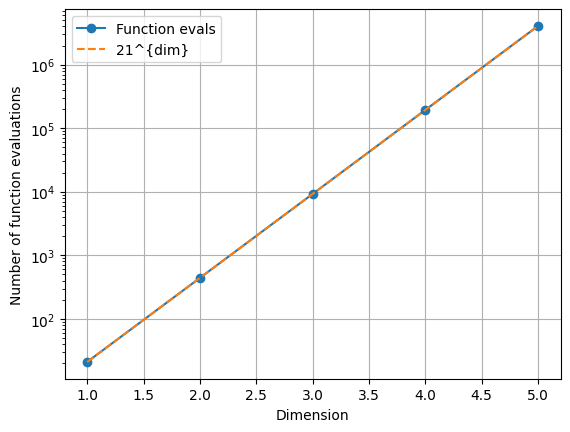

In [17]:
plt.semilogy(dimList, fevalList, 'o-', label='Function evals')
plt.semilogy(dimList, np.array(21)**dimList, '--', label='21^{dim}')
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Number of function evaluations')
plt.grid(True)
plt.show()

## Part 2: Monte Carlo

We think of $\int_{a}^b f(x)dx$ as an expected value, like
$$E[\tilde{f}] := \int_{a}^b \tilde{f}(x) p(x) dx$$
for a probability distribution $p$ (i.e., $\int_a^b p(x)dx = 1$ and $p(x)\ge 0$), with $\tilde{f}(x) := f(x)/p(x)$.

The simplest choice is the uniform distribution for $p$, so
$$p(x) = \frac{1}{b-a}.$$

Then to estimate the value of the integral, we draw random samples $x$ from this uniform distribution $p$, and then evaluate $\tilde{f}(x)$. We do this many times, to get a **sample mean**, and use that to approximate the true mean.

That's it!

### Part 2a: Monte Carlo in 1D
Plot error as a function of number of sampled points

integral=2.002200


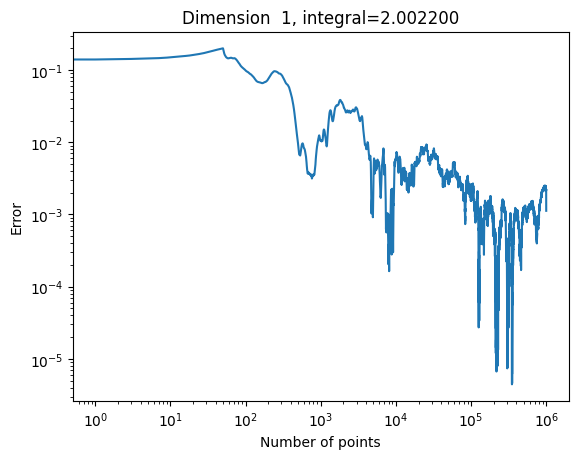

In [18]:
dim = 1
nPoints = int(1e6)
b = np.pi
a = 0

def f(X):
    """ sin(x) where x may be a matrix;
    in that case, it returns one output per row.
    For a given row, this does the product of sin(x_i) for each column i
    """
    return np.sin(X).prod(axis=1)

X = np.random.uniform(a,b, (nPoints, dim))
fX = f(X)
integral = fX.mean() * (b-a)**dim # do a cumsum later...
integral = np.power( integral, 1/dim )
print(f'{integral=:.6f}')

estimates = np.power( np.abs(np.cumsum(fX)  / np.arange(1, nPoints+1) ), 1/dim) * (b-a)
errHistory = np.abs( estimates - trueIntegral() )

# Smooth out errHistory for nicer plotting
errHistory = np.convolve(errHistory, np.ones(100)/100, mode='same')

plt.loglog(errHistory)
plt.xlabel('Number of points')
plt.ylabel('Error')
plt.title(f'Dimension {dim:2d}, {integral=:.6f}')
plt.show()


### Part 2b: Monte Carlo in high dimensions

For a range of dimensions, look at the error of Monte Carlo using 1e4 points. The answer will be random, so let's do this 100 times and average.

dim=1, integral=2.000739
dim=2, integral=1.999660
dim=3, integral=1.999930
dim=4, integral=1.999965
dim=5, integral=2.000266
dim=6, integral=2.000346
dim=7, integral=1.999926
dim=8, integral=2.000401
dim=9, integral=2.000242
dim=10, integral=1.998949


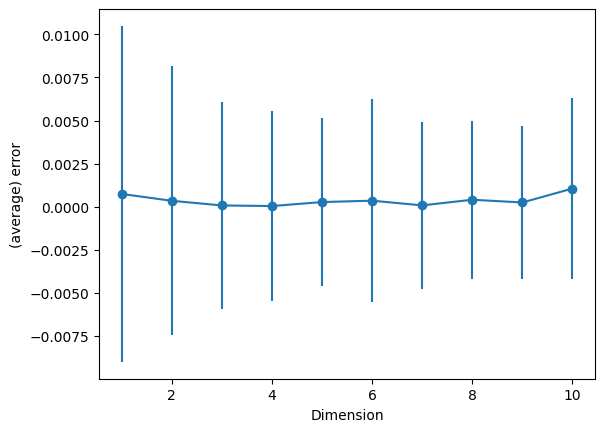

In [29]:
def f(X):
    """ sin(x) where x may be a matrix;
    in that case, it returns one output per row.
    For a given row, this does the product of sin(x_i) for each column i
    """
    return np.sin(X).prod(axis=1)

nPoints = int(1e4)
b = np.pi
a = 0

dimList = np.arange(1,11)
errList = []
errHistory = []
varHistory = [] # variance of error
for dim in dimList:

    nReps = 100
    integral = 0.
    integralSquared = 0.
    for rep in range(nReps):
        X = np.random.uniform(a,b, (nPoints, dim))
        fX = f(X)
        est = np.power( fX.mean() * (b-a)**dim, 1/dim )
        integral += est
        integralSquared += est**2
    integral /= nReps # take average
    print(f'{dim=}, {integral=:.6f}')
    errHistory.append( np.abs(integral-trueIntegral(a,b)) )
    varHistory.append( (integralSquared/nReps - integral**2) )

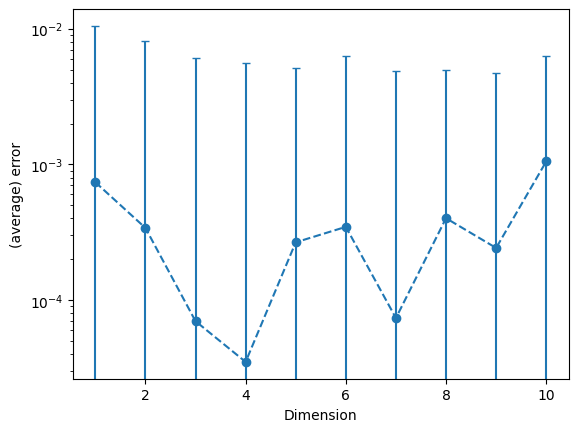

In [33]:
# plt.semilogy(dimList, errHistory, 'o-')
fig,ax = plt.subplots()
plt.errorbar(dimList, errHistory, np.sqrt(varHistory), linestyle='--', marker='o',capsize=3)
ax.set_yscale('log')
plt.xlabel('Dimension')
plt.ylabel('(average) error')
plt.show()

## Part 3: writeup
To get credit for the lab,
- write a sentence or two about your observations, and...
- from part 1b, using about 100 function evalutions, what was your accuracy?
- from part 1c, in dimension 4, how many function evaluations did you use?
- from part 2, in dimension 1, with 1000 function evaluations, what was the accuracy?'